# Apoyo Diagnostico

## Comprensión del negocio y enfoque analítico

#### Objetivo
- Identificar los problemas que tiene un paciente por medio de una descripción dada por el médico.
- Proporcionar un problema acertado en base a la descripción del médico.
#### Criterios de Exito
- El modelo proporciona un resultado asertivo con respecto a una descripción del medico. Se debe tener una exactitud mayor al 70% para considerar el modelo exitoso para el apoyo de diagnosticos medicos.
#### Tareas de Analitica
- Las tareas de analitica de textos que se consideran adecuadas para cumplir con el objetivo del negocio son clasificación y agrupación.
#### Descripción del requerimiento de negocio
- El requerimiento del negocio es resuelto por medio de clasificación ya que al tener la variable objetivo la cual seria problems_described por medio de un modelo supervisado se puede encontrar las palabras claves que determinarian el problema del paciente. Por otro lado, al usar un modelo no supervisado el cual seria agrupacion se podrian generar grupo de palabras importantes en comun para poder determinar el problema que el paciente podria llegar a tener.

## Importaciones

In [1]:
import pandas as pd
import string
import nltk
from itertools import chain
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from scipy.sparse import coo_matrix, hstack

import numpy as np
np.random.seed(3301)
# Para crear el arbol de decisión 
from sklearn.tree import DecisionTreeClassifier 
# Para realizar la separación del conjunto de aprendizaje en entrenamiento y test.
from sklearn.model_selection import train_test_split
# Para evaluar el modelo
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold
# Para resampling
from sklearn.utils import resample 
#Librerías para la visualización
import matplotlib.pyplot as plt
%matplotlib inline
# Seaborn
import seaborn as sns 
from sklearn import tree

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Lectura de archivo

In [2]:
# Lectura de los archivos proporcionados con la información de las descripciones de los medicos y el problema detectado
data_set_inicial = pd.read_csv('medical_text_clasificacion.csv')

In [3]:
# Se muestran los primeros datos del dataset para tener idea de como se veran los datos
data_set_inicial.head()

,medical_abstracts,problems_described
0,Cell lineage markers in human pancreatic cance...,1
1,Fatal pulmonary venoocclusive disease secondar...,5
2,High survival rate in advanced-stage B-cell ly...,5
3,Intracranial chordoma in a preadolescent. Case...,1
4,Analysis of prognostic factors and clinicopath...,3


In [4]:
# Se muestra la cantidad de filas y columnas que tiene el dataset
data_set_inicial.shape

(12000, 2)

In [5]:
# Se muestra el tipo de datos que tiene cada uno de las columnas
data_set_inicial.dtypes

medical_abstracts     object
problems_described     int64
dtype: object

# Analisis y perfilamiento de los datos

### Analisis de los datos en la columna problems_described

In [6]:
# Se recorre la columna de problems_described para poder ver si hay algun dato fuera de rango
for i in data_set_inicial["problems_described"]:
    if i < 0 or i > 5:
        print(i)

In [7]:
# Se cuenta la cantidad de valores de cada tipo de problema para analizar que tan repartidos estan los valores
data_set_inicial["problems_described"].value_counts().to_frame()

,problems_described
5,3993
1,2629
4,2536
3,1600
2,1242


In [8]:
# Se verifica la cantidad de valores nulos que hay en el dataset
data_set_inicial.isna().sum()

medical_abstracts     0
problems_described    0
dtype: int64

In [9]:
# Se eliminan los valores duplicados si llega a tenerlos
data_set_inicial = data_set_inicial.drop_duplicates()

### Analisis de los datos en la columna medical_abstracts

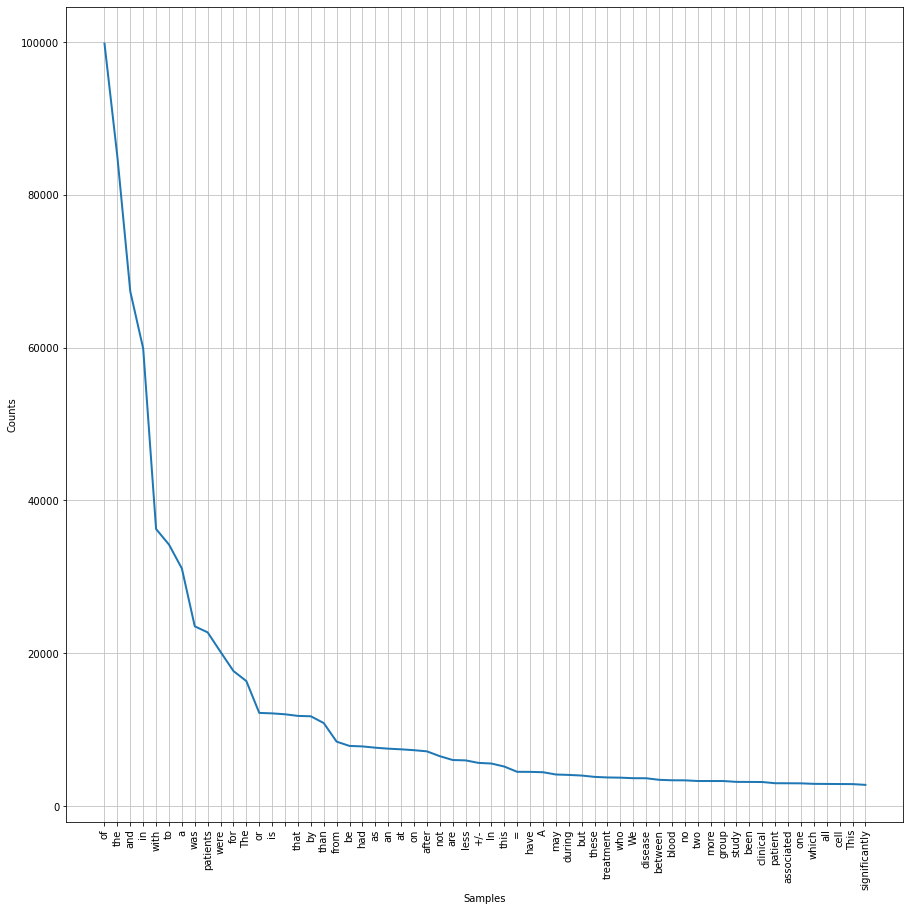

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [10]:
# Se presenta un diagrama con las palabras más comunes en todos los textos presentados en en medical abstract
frequency_dist = nltk.FreqDist(list(chain.from_iterable(data_set_inicial["medical_abstracts"].apply(lambda d: d.split(' ')).values)))
plt.figure(figsize=(15,15))
frequency_dist.plot(60,cumulative=False)

Como se puede observar en la grafica se determina que la mayoria de las palabras encontradas son las palabras más comunes en ingles que pertenecen a conectores, pronombres, entre otros. Con el fin de elaborar un estudio adecuado es necesario eliminar estas palabras y eliminar datos que no generan ningun aporte al modelo

### Arreglo de datos en la columna medical_abstracts

In [11]:
# Se genera una copia del dataset para hacer las modificaciones
data_set_texto = data_set_inicial

In [12]:
# Se recorren los textos del medical_abstract y se eliminan las puntuaciones, numeros y simbolos y se pasa todo a minusculas
for i in range(len(data_set_texto["medical_abstracts"])):
    texto = data_set_texto["medical_abstracts"][i]
    texto = texto.replace(".","")
    texto = texto.replace(";","")
    texto = texto.replace(",","")
    texto = texto.replace("(","")
    texto = texto.replace(")","")
    texto = texto.replace('"',"")
    texto = texto.replace(':',"")
    texto = texto.replace("1","")
    texto = texto.replace("2","")
    texto = texto.replace("3","")
    texto = texto.replace("4","")
    texto = texto.replace("5","")
    texto = texto.replace("6","")
    texto = texto.replace("7","")
    texto = texto.replace("8","")
    texto = texto.replace("9","")
    texto = texto.replace("0","")
    texto = texto.replace("=","")
    texto = texto.replace("%","")
    
    texto = texto.lower()
    data_set_texto["medical_abstracts"][i] = texto

In [13]:
# Se separan las palabras por espacios y remplazan por una lista de palabras
for i in range(len(data_set_texto)):
    data_set_texto["medical_abstracts"][i] = data_set_texto["medical_abstracts"][i].split(" ") 

In [14]:
# Se eliminan las palabras más comunes en ingles para poder tener un analisis mejor
s=set(stopwords.words('english'))
for i in range(len(data_set_texto["medical_abstracts"])):
    descMedicaRelevante = []
    for j in data_set_texto["medical_abstracts"][i]:
        if j not in s and j != "\n" and j != "" and j != "-":
            descMedicaRelevante.append(j)
    data_set_texto["medical_abstracts"][i] = descMedicaRelevante

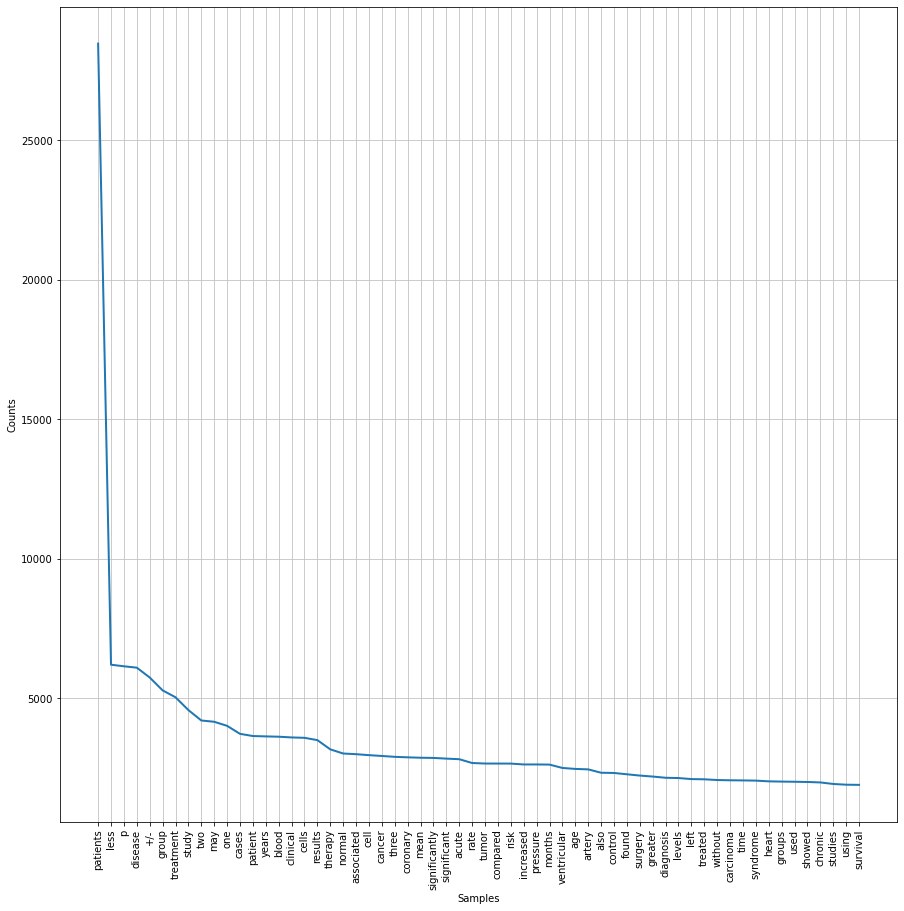

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [15]:
# Se presenta un grafico con las palabras más comunes en todos los textos
frequency_dist = nltk.FreqDist(list(chain.from_iterable(data_set_texto["medical_abstracts"].values)))
plt.figure(figsize=(15,15))
frequency_dist.plot(60,cumulative=False)

In [16]:
# Se presenta un conteo de la cantidad de valores diferentes que hay
len(list(chain.from_iterable(data_set_texto["medical_abstracts"].values))) 

1299229

In [17]:
# Se convierte el arreglo a texto para poder realizar el analisis esperado
text=data_set_texto["medical_abstracts"].apply(lambda d: ' '.join(d)).copy()
data_set_texto["medical_abstracts"] = text
data_set_texto.head()

,medical_abstracts,problems_described
0,cell lineage markers human pancreatic cancer n...,1
1,fatal pulmonary venoocclusive disease secondar...,5
2,high survival rate advanced-stage b-cell lymph...,5
3,intracranial chordoma preadolescent case repor...,1
4,analysis prognostic factors clinicopathologica...,3


## Modelamiento y Evaluacion

In [18]:
# Se vectorizan los datos de texto
tfidf_text=TfidfVectorizer(max_features=20000).fit(text)

In [19]:
# Se vectorizan los valores en la columna medical abstract para hacer el modelamiento
df_model = data_set_texto
X_text=tfidf_text.transform(df_model["medical_abstracts"])

### Random Forest Classifier

In [20]:
# Se definen los parametros a usar en el modelo de random forest
parameters={'criterion':["gini","entropy"],'n_estimators':[50,100,150]}

In [21]:
# Se implementa el modelo random forest
RFC=RandomForestClassifier(n_jobs=-1)

In [22]:
# Se genera el modelo
RFC_best=GridSearchCV(RFC,parameters).fit(X_text,df_model["problems_described"].values).best_estimator_

In [23]:
# Se imprime el reporte con las predicciones por cada uno de los problemas
print(classification_report(df_model["problems_described"].values, RFC_best.predict(X_text), labels=[1, 2, 3, 4, 5]))

              precision    recall  f1-score   support

           1       0.84      0.90      0.87      2629
           2       0.79      0.72      0.76      1242
           3       0.82      0.76      0.79      1600
           4       0.82      0.89      0.85      2536
           5       0.79      0.76      0.78      3993

    accuracy                           0.81     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.81      0.81      0.81     12000



### Árbol de decisión (DecissionTreeClassifier)

#### Datos proporcionados

In [24]:
CV = CountVectorizer(stop_words='english')
data_matrix = CV.fit_transform(df_model["medical_abstracts"])
nombres_columnas = CV.get_feature_names() # palabras

C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [25]:
# Crear dataset con la matriz y los nombres de columnas
data_set_arbol = pd.DataFrame(data_matrix.toarray(),columns=nombres_columnas)
data_set_arbol['label']=df_model["problems_described"]
data_set_arbol.head()

,aa,aaa,aab,aaem,aag,aah,aai,aapo,aaron,aas,...,zygosity,zyloric,zymodeme,zymodemes,zymogen,zymogens,zymograms,zymography,zymosan,zzygos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Verificación de la tabla de datos

In [26]:
data_set_arbol

,aa,aaa,aab,aaem,aag,aah,aai,aapo,aaron,aas,...,zygosity,zyloric,zymodeme,zymodemes,zymogen,zymogens,zymograms,zymography,zymosan,zzygos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
data_set_arbol.describe()

,aa,aaa,aab,aaem,aag,aah,aai,aapo,aaron,aas,...,zygosity,zyloric,zymodeme,zymodemes,zymogen,zymogens,zymograms,zymography,zymosan,zzygos
count,12000.000000,12000.000000,12000.000000,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,...,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,0.002167,0.001500,0.000583,0.00025,0.000167,0.000167,0.001000,0.000083,0.000083,0.000167,...,0.00025,0.000083,0.000083,0.000250,0.001333,0.000167,0.000167,0.000083,0.001000,0.000167
std,0.077433,0.099993,0.063901,0.01581,0.018257,0.018257,0.061908,0.009129,0.009129,0.012909,...,0.01581,0.009129,0.009129,0.027386,0.046530,0.018257,0.012909,0.009129,0.040814,0.012909
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,9.000000,7.000000,1.00000,2.000000,2.000000,6.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,3.000000,2.000000,2.000000,1.000000,1.000000,3.000000,1.000000


### Modelo

In [28]:
# Se selecciona la variable objetivo
Y = data_set_arbol['label']
# Del conjunto de datos se elimina la variable target. En este caso, se realizaó el cambio de categoricos a numericos en el
# modelamiento.
X = data_set_arbol.drop(['label'], axis=1)

In [29]:
# Dividir los datos en entrenamiento y test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [30]:
# Se fija el número de particiones. Se usará K = 10. En este caso se deja comentado debido al inmenso tamaño de la tabla para 
# el arbol a crear.
particiones = KFold(n_splits = 10, shuffle = True, random_state = 0)

# Se establece el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [4, 6, 8, 10, 20], 'min_samples_split': [2, 3, 4, 5]}

# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol_inicial = DecisionTreeClassifier(random_state = 0)

# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada. En este caso, para que no se
# demore el algoritmo se elige un valor de las particiones de 5.
mejor_modelo = GridSearchCV(arbol_inicial, param_grid, cv = particiones)

# Ajuste del modelo
mejor_modelo.fit(X_train, Y_train)

# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 2}

In [31]:
# Obtener el mejor modelo.
arbol = mejor_modelo.best_estimator_

#### Evaluacion del árbol

In [32]:
# Probemos ahora este modelo sobre test.
y_pred_train = arbol.predict(X_train)
y_pred_test = arbol.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(Y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(Y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.53
Exactitud sobre test: 0.52


Datos de entrenamiento
              precision    recall  f1-score   support

           1       0.73      0.68      0.70      2076
           2       0.53      0.04      0.08      1005
           3       0.69      0.04      0.08      1272
           4       0.70      0.59      0.64      2013
           5       0.42      0.76      0.54      3234

    accuracy                           0.53      9600
   macro avg       0.61      0.42      0.41      9600
weighted avg       0.59      0.53      0.49      9600



C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


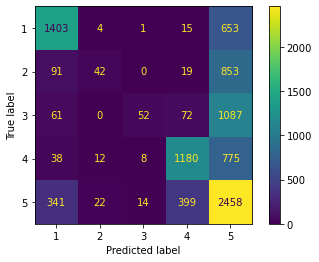

In [33]:
# Se imprime el informe de rendimiento
print("Datos de entrenamiento")
print(classification_report(Y_train, y_pred_train))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol, X_train, Y_train)  
plt.show()

Datos de prueba
              precision    recall  f1-score   support

           1       0.71      0.67      0.69       553
           2       0.40      0.03      0.06       237
           3       0.35      0.02      0.04       328
           4       0.71      0.56      0.63       523
           5       0.40      0.75      0.52       759

    accuracy                           0.52      2400
   macro avg       0.51      0.41      0.39      2400
weighted avg       0.53      0.52      0.47      2400



C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


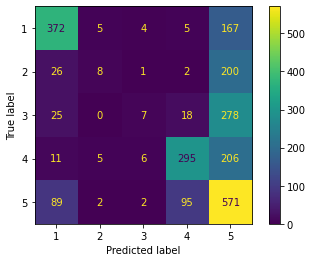

In [34]:
# Se imprime el informe de rendimiento
print("Datos de prueba")
print(classification_report(Y_test, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(arbol, X_test, Y_test)  
plt.show()

#### Interpretacion del modelo

Podemos determinar cuáles palabras son las más importantes a partir del modelo generado, ya se ve el arbol y la probabilidad de que un dato sea clasificado en una categoría puntual.

In [35]:
# Obtener la importancia de las variables. Mientras mayor el coeficiente, más la importancia.
importancia_atributo = pd.DataFrame(data={"Atributo": X_train.columns, "Importancia": arbol.feature_importances_})
importancia_atributo = importancia_atributo.sort_values(by = 'Importancia', ascending = False).reset_index(drop = True)
importancia_atributo

,Atributo,Importancia
0,tumor,0.202276
1,coronary,0.149179
2,cancer,0.137632
3,ventricular,0.089773
4,carcinoma,0.083168
...,...,...
32913,fivefold,0.000000
32914,fitting,0.000000
32915,fitted,0.000000
32916,fits,0.000000


Esta información es muy útil para el negocio, pues le permite entender la influencia de cada palabra para la determinación de un problema médico. En este caso, se da relevancia a los problemas en el cuerpo y palabras que representaen enfermedades.

A continuación se muestran las 30 palabras mas importantes, para brindar un enfasis que se derivo del algoritmo.

In [40]:
feature_importance = pd.DataFrame(arbol.feature_importances_, index=X_train.columns)
print(feature_importance.sort_values(by=0, ascending=False)[:30])

                           0
tumor               0.202276
coronary            0.149179
cancer              0.137632
ventricular         0.089773
carcinoma           0.083168
hypertension        0.077397
leukemia            0.048860
heart               0.039458
portal              0.017475
intracranial        0.007112
shunt               0.006114
nerve               0.005929
stroke              0.005254
left                0.005062
pain                0.004307
cholesterol         0.004269
chest               0.003993
biliary             0.003974
cardiovascular      0.003858
showed              0.003843
bypass              0.003562
resonance           0.003282
progressive         0.003238
disorder            0.003156
polyps              0.003124
cns                 0.003062
cell                0.002990
tnf                 0.002734
neurodevelopmental  0.002698
transformation      0.002660


### Gradient Boosting

In [41]:
from sklearn.ensemble import GradientBoostingClassifier

In [43]:
# Se selecciona la variable objetivo
Y = df_model['problems_described']
# Del conjunto de datos se elimina la variable target. En este caso, se realiza el cambio de categoricos a numericos en el
# modelamiento.
X = X_text

In [44]:
# Dividir los datos en entrenamiento y test
X_train_gb, X_test_gb, Y_train_gb, Y_test_gb = train_test_split(X, Y, test_size = 0.2, random_state = 0)

In [45]:
best_model_gradient = GradientBoostingClassifier(random_state = 0, n_estimators= 150)
best_model_gradient.fit(X_train_gb, Y_train_gb)

GradientBoostingClassifier(n_estimators=150, random_state=0)

Datos de prueba
              precision    recall  f1-score   support

           1       0.71      0.67      0.69       553
           2       0.40      0.03      0.06       237
           3       0.35      0.02      0.04       328
           4       0.71      0.56      0.63       523
           5       0.40      0.75      0.52       759

    accuracy                           0.52      2400
   macro avg       0.51      0.41      0.39      2400
weighted avg       0.53      0.52      0.47      2400



C:\Users\User\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


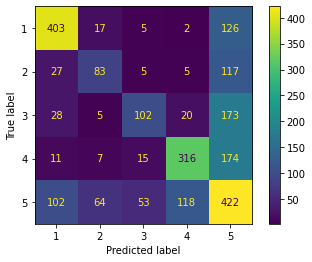

In [46]:
# Se imprime el informe de rendimiento
print("Datos de prueba")
print(classification_report(Y_test_gb, y_pred_test))
# Se puede visualizar la matriz de confusión
plot_confusion_matrix(best_model_gradient, X_test_gb, Y_test_gb)  
plt.show()

### Support Vector Classifier

In [48]:
from sklearn.naive_bayes import BernoulliNB

In [49]:
parameters={'alpha':[0,0.5,1]}

In [50]:
BNB=BernoulliNB()
BNB_Best=GridSearchCV(BNB,parameters).fit(X_text,df_model["problems_described"].values).best_estimator_

C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\naive_bayes.py:555: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn(


In [51]:
print(classification_report(df_model["problems_described"].values, BNB_Best.predict(X_text), labels=[1, 2, 3, 4, 5]))

              precision    recall  f1-score   support

           1       0.74      0.83      0.78      2629
           2       0.61      0.83      0.70      1242
           3       0.60      0.78      0.68      1600
           4       0.70      0.79      0.74      2536
           5       0.73      0.44      0.55      3993

    accuracy                           0.69     12000
   macro avg       0.68      0.73      0.69     12000
weighted avg       0.70      0.69      0.67     12000

